In [4]:
N=20
coords_2D=np.random.random_sample((N,2,2))
coords_1D=np.random.random_sample((N,1,2))
coords_5D=np.random.random_sample((10,5,2))

# Protocols

In [5]:
import sus.library.example_substages as ESS

erase_prot=ESS.CP

tilt=ESS.tilt
untilt=ESS.untilt
lower=ESS.lower
unlower=ESS.unlower

In [ ]:
# we can look at the signal a compound protocol generates over time:
erase_prot.show_params()

# by default it only shows the nontrivial parameters (the ones that are not constant)
# we can show all by using
erase_prot.show_params(which='all')

# this protocol has 12 parameters, but most of them are trivial
# you could also show any subset of parameters by specifying an explicit "which":
erase_prot.show_params(which=[1,2,7,9])

In [9]:
# if you want just the initial and final time of the whole protocol:
print('initial time:',erase_prot.t_i)
print('final time:',erase_prot.t_f)

initial time: 0.0
final time: 1.0


In [10]:
#if you just want a printout that tells you what each time corresponds to:
erase_prot.show_substage_times()

stage 1 times: [0.   0.25]
stage 2 times: [0.25 0.5 ]
stage 3 times: [0.5  0.75]
stage 4 times: [0.75 1.  ]


In [11]:
#For a simple protocol, there are no substages:

#if we look at the protocol that is just one of the substages (called 'tilt') we can still use
#Protocol.t_i and Protocol.t_f to give initial and final times of the protocol:
print('initial time is:',tilt.t_i)
print('final time is:',tilt.t_f)

initial time is: 0.25
final time is: 0.5


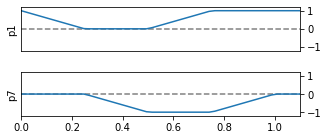

(<Figure size 360x144 with 2 Axes>,
 array([<AxesSubplot:ylabel='p1'>, <AxesSubplot:ylabel='p7'>], dtype=object))

In [12]:
# we have different interpolation methods as well, here is a plot of the nontrivial parameters in this 
# erase protocol
# note that the interpolation from one substage to another is linear:
erase_prot.show_params()

In [13]:
# Compound_Protocol.protocols gives a list of all the substage protocols that make up the compound one.
# here we see the first substage uses a linear interpolation:
erase_prot.protocols[0].interpolation

'linear'

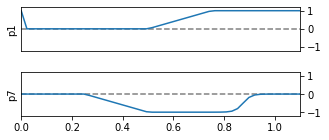

(<Figure size 360x144 with 2 Axes>,
 array([<AxesSubplot:ylabel='p1'>, <AxesSubplot:ylabel='p7'>], dtype=object))

In [14]:
# but, we can change the interpolation as follows. currently there are two other modes 'step' and 'sigmoid'
erase_prot.protocols[0].interpolation = 'step'
erase_prot.protocols[3].interpolation = 'sigmoid'
erase_prot.show_params()

# Applying Protocols to Potentials using a System

In [15]:
#initialize our full system:
# There's no error because both the erase_prot and blw have the same number of parameters

erase_sys=System(erase_prot,blw)

In [16]:
%%capture
# Visualization tools

# You can animate the protocol by seeig how it affects the potential over time
ani=erase_sys.animate_protocol(mesh=30);

#There is a workaround below make the animatio show in jupyter notebook,
#Normally you could just do plt.show() to show the animation. 
HTML(ani.to_jshtml(fps=5))

In [ ]:
#to see just a certain point in time, t,  use show_potential(t)
# the surface argument determines if we see a wireframe or a contour plot.
erase_sys.show_potential(0.4)
erase_sys.show_potential(0.4, surface=True)

In [19]:
# you can pull out forces, the potential, or the energy given a set of coordiantes and a time 
# note the total energy assumes a kinetic energy given by 1/2 mv^2, it takes in a mass argument 
# but the default is unit mass

potentials=erase_sys.get_potential(coords_2D, .7)
print('potentials for trials 11-15:', potentials[10:15])

energy = erase_sys.get_energy(coords_2D, 0)
print('KE+U for the same coordinates',energy[10:15])

# the output for forces is in the form (N,D): N sets of D forces
forces=erase_sys.get_external_force(coords_2D, .5)
print('forces for trial 4:{}'.format(forces[3]))
print('forces in the "y" direction for all trials 1-4:', forces[0:4,1])

potentials for trials 11-15: [12.25605811 12.31208589 14.34747052 12.94087644 14.66157675]
KE+U for the same coordinates [16.31031673 15.73521131 17.59687661 16.20240303 17.67932963]
forces for trial 4:[ 6.65457388 -1.21873678]
forces in the "y" direction for all trials 1-4: [-0.01125248 -0.2159645   0.28617906 -1.21873678]


# Creating new potentials

##### Lets say we want to make a new kind of potential, say a 2 dimensional potential that is an exponential well at (x,y)=0

$$ V= - e^{-\frac{ax^2+by^2}{T}} $$

##### We have 3 parameters to deal with (a, b and T). All we need to do is make a function to give us the potential and the force
##### It is good practice to stick to the following docstring format when making the potential function.
##### It makes it easier to collaborate with others/yourself.

In [20]:
from numpy import exp as exp

def exp_well_pot(x, y, params):
    '''
    2D potential, an exponential well centered at (0,0)
    with a variable aspect ratio
    
    Parameters
    ----------
    x,y : ndarray of dimension [N_coord,]
        these are lists of the x and y values where we want to find the potential
    params: list [a,b,T]
        a,b : the scale at which the x and y directions change the value of the potential
        T : the overall 'temperature' scale: affects both x and y directions equally
        
    Returns
    -------
    the value of the potential at locations x,y with the given params
    '''
    a, b, T = params
    return(-exp(-(a*x**2+b*y**2)/T))

def exp_well_force(x, y, params):
    '''
    See the exp_well_pot function, it has the same input format
    '''
    a, b, T = params
    dx= 2*a*x*exp(-(a*x**2+b*y**2)/T)/T
    dy= 2*a*y*exp(-(a*x**2+b*y**2)/T)/T
    return(-dx,-dy)
   

In [21]:
# definine a new potential class takes a potential function and a force function as inputs.
# also you need to put in the number of parameters (3 here) and the number of dimensions (2 here)
exp_well = Potential(exp_well_pot,exp_well_force,3,2)  

# we can go ahead and look at it now by sending it through a System using Potential.trivial_protocol
# this just sets all parameters to 1(or default values if they exist) and the time window from 0 to 1

# the default parameters can be redefined when you instance a Potential class 
# by passing a list of the default parameters
# such as exp_well=Potential(exp_well_pot, exp_well_force, 3, 2, default_params=(3,8,.1))

# additionally, you can set a relevant domain: range of coordiantes you expect to care about:
# domain = [[-3,-2], [3,2]] would set the x and y domains to be [-3,3] and [-2,2], respectively 
# exp_well=Potential(exp_well_pot, exp_well_force, 3, 2, relevant_domain=domain)

trivial_system = System(exp_well.trivial_protocol(),exp_well)

In [ ]:
trivial_system.show_potential(100)

# Creating new protocols

In [23]:
# Generally,  we want make a protocol that will operate on the potential. This protocol will go from t=0 to t=.6
t=[0,.6]
#we'll interpolate from a totally symmetric well (a=1,b=1,T=1) to a deformed well at the same T (a=.5,b=2,T=1) 
params=[[1,.2],[1,3],[1,1]]

#now, we make a protocol. WSP is short for well_stetch_protocol
WSP=Protocol(t,params)

In [24]:
#Finally, we apply the well stretch protocol to the exp_well potential
well_stretch=System(WSP,exp_well)

In [ ]:
#and just to make sure it worked as expected, lets plot it:
well_stretch.show_potential(0)

well_stretch.show_potential(.05)

#you can specify a manual domain, if you want.
well_stretch.show_potential(.5)

well_stretch.show_potential(.7)

# Editing Protocols

In [26]:
#lets say we want to make a compound protocol that stretches the well and then unstretches it
#here we can call the reverse method of protocols, which reverses all parameters but NOT the times.

# it is functionally equivalent to  redefining the input params from ((a,b),(c,d),(e,f)) to ((b,a),(d,c),(f,e))

#first make a copy of the original protocol
WSP_rev=WSP.copy()
#then call the reverse method to reverse the parameters for the copy
WSP_rev.reverse()


In [27]:
#so we need to time shift the second one to start at some point after t=.6
#use Protocol.time_shift for this:

print(f"Before the shift, WSP_rev initial time is: {WSP_rev.t_i}, WSP_rev final time is: {WSP_rev.t_f}")

WSP_rev.time_shift(WSP.t_f)

print(f"After the shift, WSP_rev initial time is: {WSP_rev.t_i}, WSP_rev final time is: {WSP_rev.t_f}")


Before the shift, WSP_rev initial time is: 0.0, WSP_rev final time is: 0.6
After the shift, WSP_rev initial time is: 0.6, WSP_rev final time is: 1.2


In [28]:
#If we do this several times in a row, it will keep shifting the protocol times. 
print("WSP_rev initial time is:",WSP_rev.t_i,"WSP_rev final time is:",WSP_rev.t_f)
WSP_rev.time_shift(WSP.t_f)
print("initial time is:",WSP_rev.t_i,"final time is:",WSP_rev.t_f)

WSP_rev initial time is: 0.6 WSP_rev final time is: 1.2
initial time is: 1.2 final time is: 1.7999999999999998


In [29]:
# Lets make a compound protocol, to see what happens in this case. 
# Note that we don't need to time order the substages, the class initialization will do that for us

SAR_prot=Compound_Protocol((WSP_rev,WSP))
SAR_prot.show_substage_times()

# it's okay that there is some dead space between the protocol steps, the protocol assumes that to mean that 
# we keep the parameters constant in the meantime.



stage 1 times: [0.  0.6]
stage 2 times: [1.2 1.8]


In [30]:
#now we can apply the compound protocol made of stretch and unstretch:
stretch_and_rev=System(SAR_prot,exp_well)

In [31]:
%%capture
# now we can see the whole protocol:
# well put a manual domain in the animate_protocol method, because if we dont the well 
# will stretch far out of our default domain of -2,2
ani=stretch_and_rev.animate_protocol(surface=False, manual_domain = [[-3, -3], [3,3]] )
HTML(ani.to_jshtml(fps=10))
#note that parameters are held fixed between the explicit substages to fill in the gaps

In [33]:
# we can also edit protocols that we have already made with the Protocol.change_param method
# lets say we want the first parameter in our reverse process to actually go from .2 to 3 instead of down to 1

print(WSP_rev.params)
#we now call the change_param method, which takes in which parameters you want to change 
#and new initial and final values
WSP_rev.change_params(1,(.2,3))

print(WSP_rev.params)


[[0.2 1. ]
 [3.  1. ]
 [1.  1. ]]
[[0.2 3. ]
 [3.  1. ]
 [1.  1. ]]


In [34]:
# if we want to make the WSP_rev stage of the protocol take longer
# we can use Protocol.time_stretch for that
print(WSP_rev.t_i,WSP_rev.t_f)
WSP_rev.time_stretch(3)
print(WSP_rev.t_i,WSP_rev.t_f)

1.2 1.7999999999999998
1.2 2.9999999999999996


In [35]:
%%capture
SAR_slow = Compound_Protocol((WSP,WSP_rev))
SAR_slow_sys=System(SAR_slow, exp_well)

ani=SAR_slow_sys.animate_protocol(surface=False)
HTML(ani.to_jshtml(fps=10))

In [37]:
#the normalize method will always set the overall time interval to be 1 time unit while keeping the 
# relative lengths equal
"""Why no differences between the two?"""
print('before normlize')
SAR_slow.time_stretch(3)
SAR_slow.show_substage_times()

SAR_slow.normalize()

print('after normalize:')
SAR_slow.show_substage_times()

before normlize
stage 1 times: [0.  1.8]
stage 2 times: [3.6 9. ]
after normalize:
stage 1 times: [0.  0.2]
stage 2 times: [0.4 1. ]


# Working With built-in potentials

In [40]:
from sus.protocol_designer.protocol import sequential_protocol

In [42]:
# as an example, let's make Alec's version of the Szilard Engine. This operates on the coupled Duffing_2D potential
from sus.library.potentials import duffing_2D

#out of the 7 possible parameters in this potential, 3 of them are held fixed at the default value for
#the potential (can be accessed with Potential.default_params, if its not defined the default will set all
# parameters to 0)
duffing_2D.default_params

(1.0, 1.0, -1.0, -1.0, 0, 0, 0)

In [43]:
# in this version of szilards engine, we keep everything fixed except for the 3rd, 4th, 6th, and 7th parameters.
# it is a 12 step protocol, so there are 13 places we need to define the changing parameters including
# the start point and the end point

p3 = (-1, -1, -1, -1, -1, 0, 0, -1, -1, -1, -1, -1, -1)
p4 = (-1, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, -1, -1)
p6 = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0)
p7 = (0, 0, -1, -1, 0, -1, -1, 0, 0, 0, 0, 0, 0)

# we prepare a list of the which parameters will change, and also their values at each substage time
which=(3,4,6,7)
non_triv_param=(p3,p4,p6,p7)
# there are 12 steps
NS=12
#and 7 parameters
NP=7

# Working With Built In Systems

In [45]:
from sus.library.szilard_protocols import ew2_szilard as exp_szilard
system = exp_szilard

In [46]:
# the above is a different implementation of szilards engine, using exponentially localized wells

In [48]:
#the default locations of the wells are at locations (-1,-1), (1,1), etc... (parameters 9-16)
system.potential.default_params

(1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1)

In [49]:
# lets say we want to make them all be closer to the origin, we can edit the protocol.parameters arttribute
# but it is a little tricky because this is a many-substage protocol,
# so well need to edit the parameters for each substage

# substages are stored in the Compound_Protocol.protocols

# one way to do this is to loop through each protocol in protocols and use the change_param method

In [50]:
r=.6
new_params= r* system.protocol.params[8:16]
for item in system.protocol.protocols:
    item.change_params((9,10,11,12,13,14,15,16),new_params)

#if we wanted to do this in a non destructive way, we could first make a new copy
#    new_sys = system.copy()
#    and then operate on new_sys


In [51]:
%%capture
ani=system.animate_protocol(n_contours=20, surface=True, manual_domain=[[-1,-1],[1,1]])
HTML(ani.to_jshtml(fps=8))

In [54]:
source_path = os.path.expanduser('~/Project/source/')
sim_path = os.path.dirname(source_path + "simtools/infoenginessims/")
sys.path.append(sim_path)

from simulation import Simulation